In [1]:
%load_ext autoreload
%autoreload 2

import os
from os.path import join
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch
import pandas as pd
mpl.style.use('style.mcstyle')

In [2]:
# Load data

wdir = '/Users/maho/git/ili-topology/data'
# os.listdir(wdir)

x = np.load(join(wdir, 'a_lm_T_E18_10k.npy'))
y = np.load(join(wdir, 'a_lm_T_E1_Lxyz_0p5_10k.npy'))
x.shape, y.shape

((10000, 496), (10000, 496))

Text(0, 0.5, 'a_lm, imaginary part')

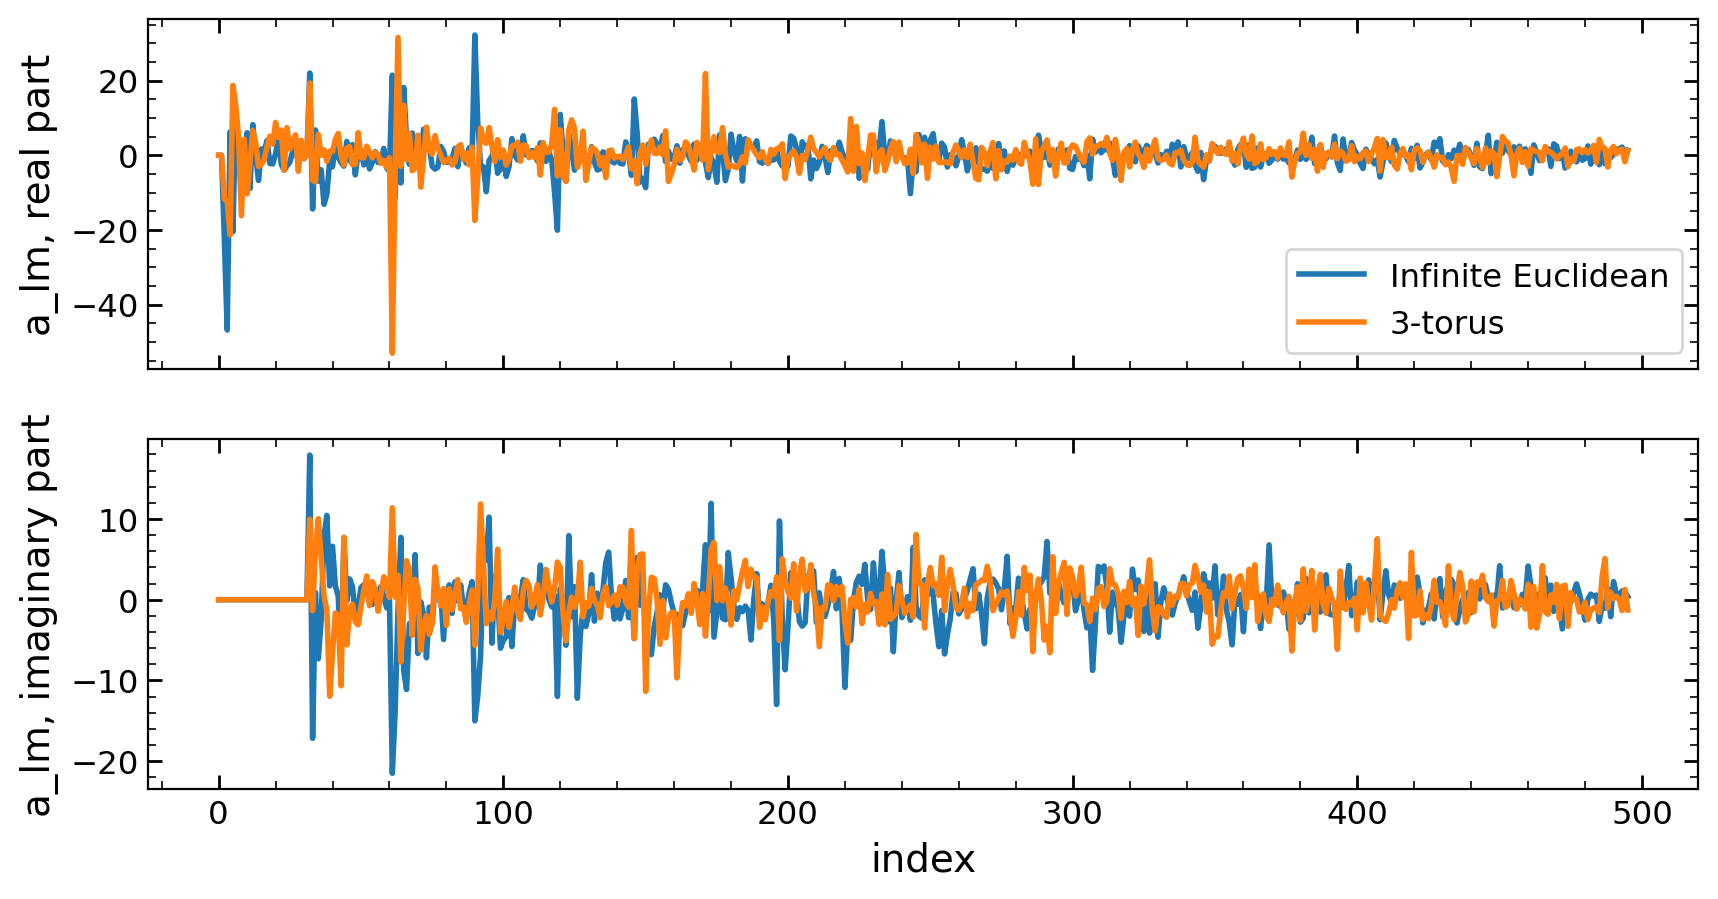

In [3]:
i = 0

f, axs = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
ax = axs[0]
ax.plot(x[i].real, label='Infinite Euclidean')
ax.plot(y[i].real, label='3-torus')
ax.legend()
ax.set_ylabel('a_lm, real part')

ax = axs[1]
ax.plot(x[i].imag, label='Infinite Euclidean')
ax.plot(y[i].imag, label='3-torus')
ax.set_xlabel('index')
ax.set_ylabel('a_lm, imaginary part')


## UMAP compression

/opt/homebrew/anaconda3/envs/ili-torch/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/anaconda3/envs/ili-torch/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


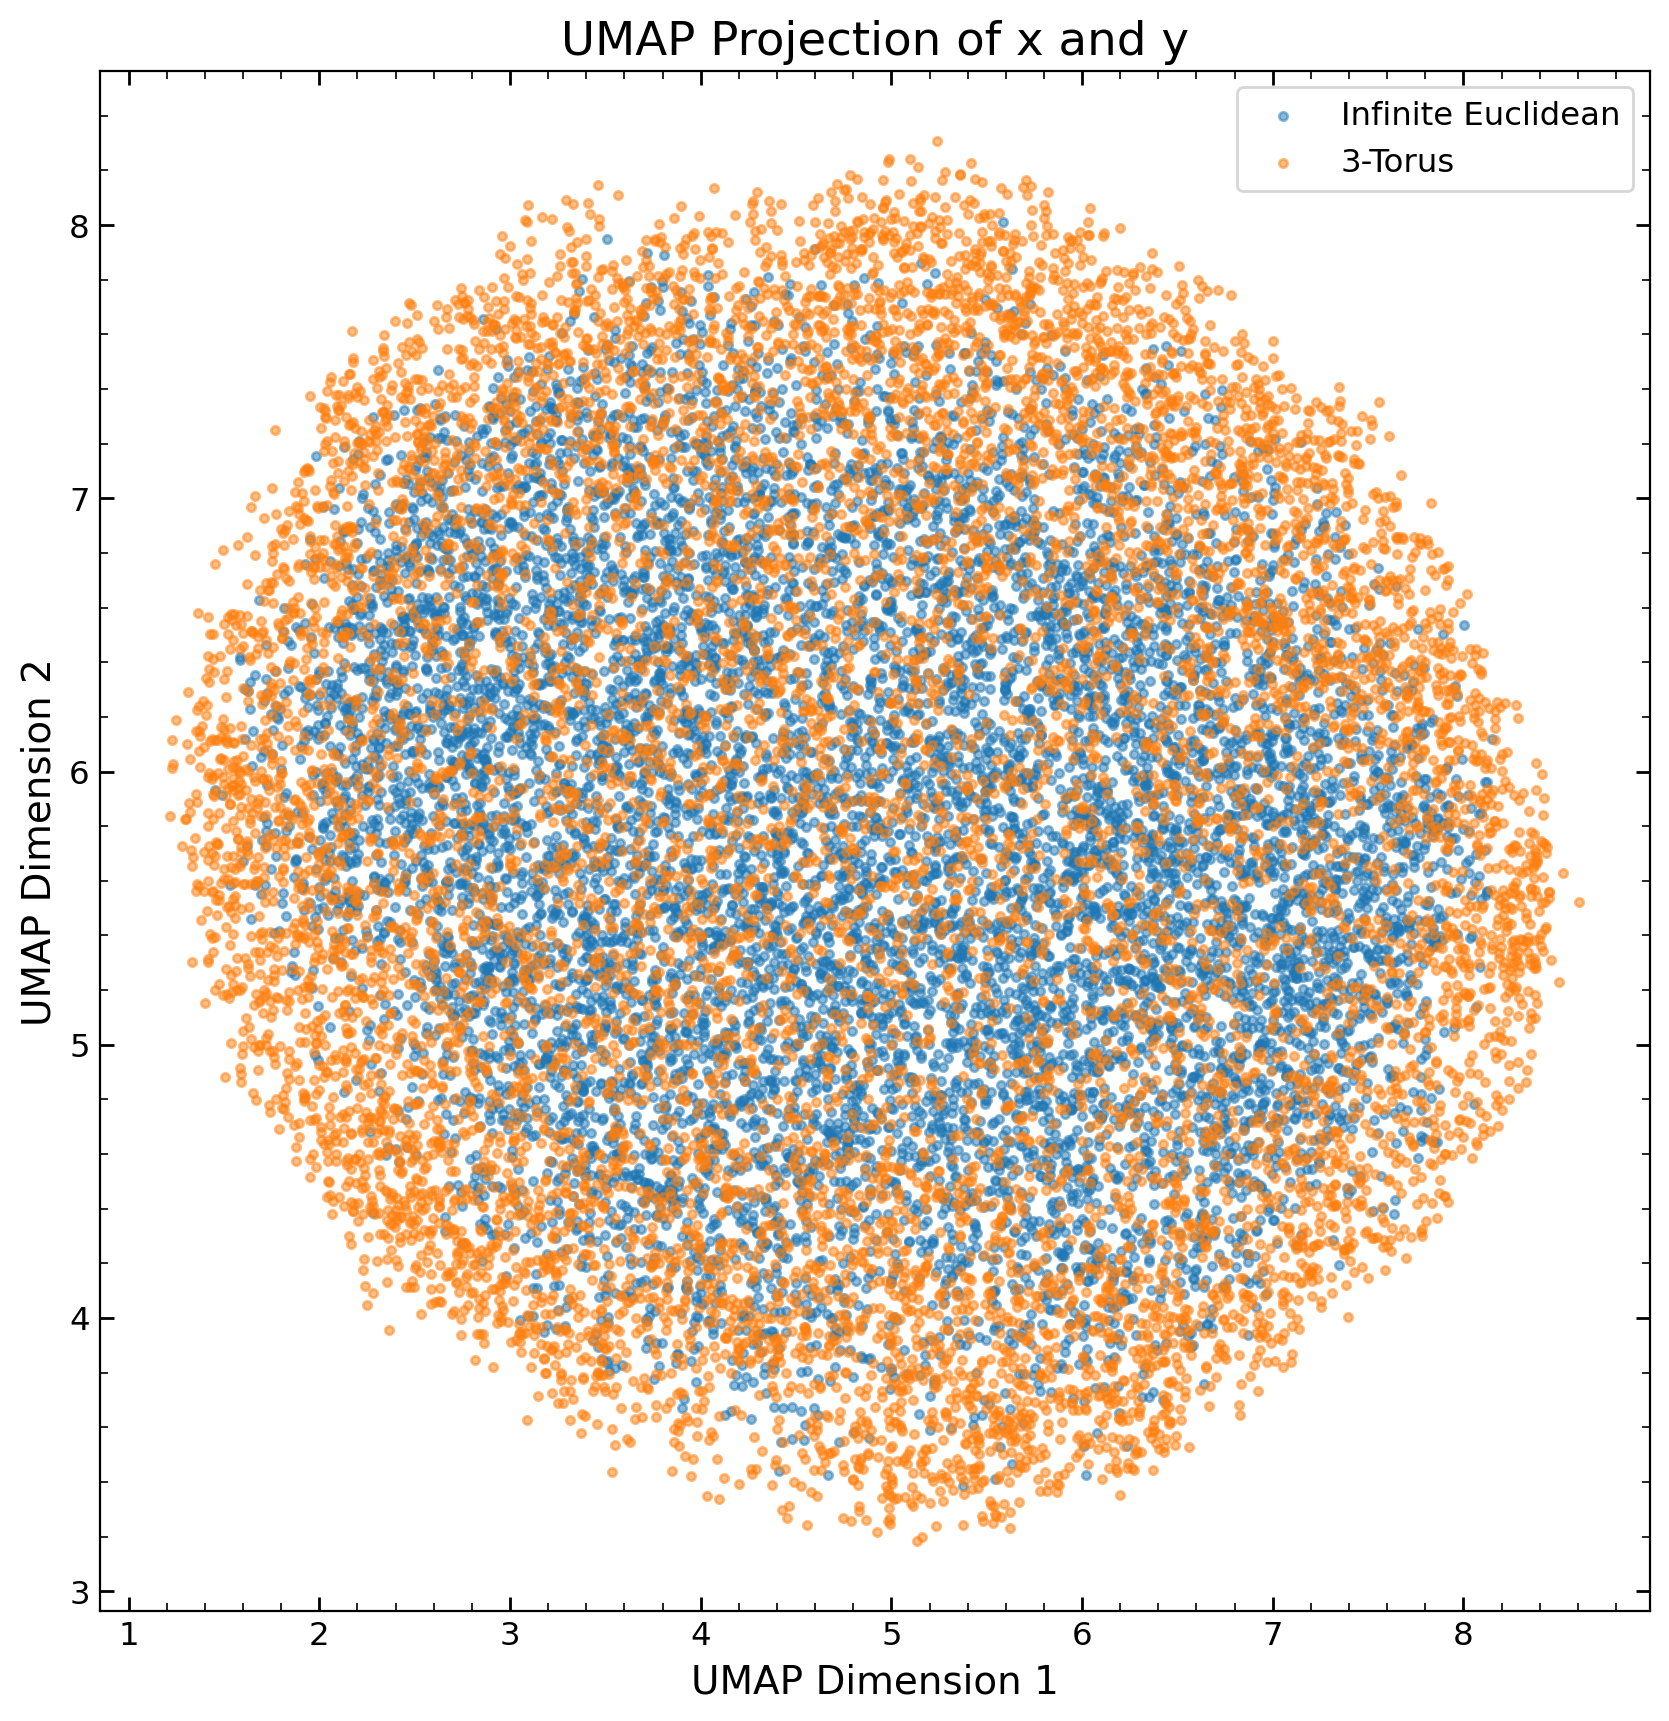

In [4]:
import umap

# Flatten the complex arrays into real and imaginary parts
data = np.vstack([np.hstack([x.real, x.imag]), np.hstack([y.real, y.imag])])

# Fit UMAP
reducer = umap.UMAP(n_components=2, random_state=42)
embedding = reducer.fit_transform(data)

# Split the embeddings back into x and y
embedding_x, embedding_y = embedding[:x.shape[0]], embedding[x.shape[0]:]

# Plot the embeddings
plt.figure(figsize=(10, 10))
plt.scatter(embedding_x[:, 0], embedding_x[:, 1], label='Infinite Euclidean', marker='.', alpha=0.5)
plt.scatter(embedding_y[:, 0], embedding_y[:, 1], label='3-Torus', marker='.', alpha=0.5)
plt.legend()
plt.title('UMAP Projection of x and y')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()

## Classical classification

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

# Prepare the data
x_flat = np.hstack([x.real, x.imag])
y_flat = np.hstack([y.real, y.imag])
X = np.vstack([x_flat, y_flat])
y_labels = np.array([0] * x_flat.shape[0] + [1] * y_flat.shape[0])  # 0 for x, 1 for y

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_labels, test_size=0.3, random_state=42)

# Train a logistic regression classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3017
           1       0.99      0.97      0.98      2983

    accuracy                           0.98      6000
   macro avg       0.98      0.98      0.98      6000
weighted avg       0.98      0.98      0.98      6000



## Evidence ratios

In [4]:
import ili
from ili.dataloaders import NumpyLoader

In [5]:
from sklearn.model_selection import train_test_split

# Prepare the data
x_flat = np.hstack([x.real, x.imag])
y_flat = np.hstack([y.real, y.imag])
X = np.vstack([x_flat, y_flat])
y_labels = np.array([0] * x_flat.shape[0] + [1] * y_flat.shape[0])  # 0 for x, 1 for y

# Split into train/test and build loaders
X_train, X_test, y_train, y_test = train_test_split(
    X, y_labels, test_size=0.1, random_state=11)

X_train /= 100
X_test /= 100

# # Build loaders
m = y_train==0
loader1_train = NumpyLoader(X_train[m], y_train[m])
loader2_train = NumpyLoader(X_train[~m], y_train[~m])

m = y_test==0
loader1_test = NumpyLoader(X_test[m], y_test[m])
loader2_test = NumpyLoader(X_test[~m], y_test[~m])

In [14]:
from ili.evidence import K_EvidenceNetwork

runner = K_EvidenceNetwork(
    layer_width=32, added_layers=2,
    batch_norm_flag=1, alpha=2,
    train_args=dict(
        max_epochs=10000, learning_rate=1e-6,
        training_batch_size=64,
        stop_after_epochs=20,
        validation_fraction=0.1)
)

In [15]:
summary = runner.train(loader1_train, loader2_train)

431 epochs [03:54,  1.84 epochs/s, loss_train=-1.27, loss_val=-0.557]      


[Text(0.5, 0, 'Epochs'), Text(0, 0.5, 'Loss')]

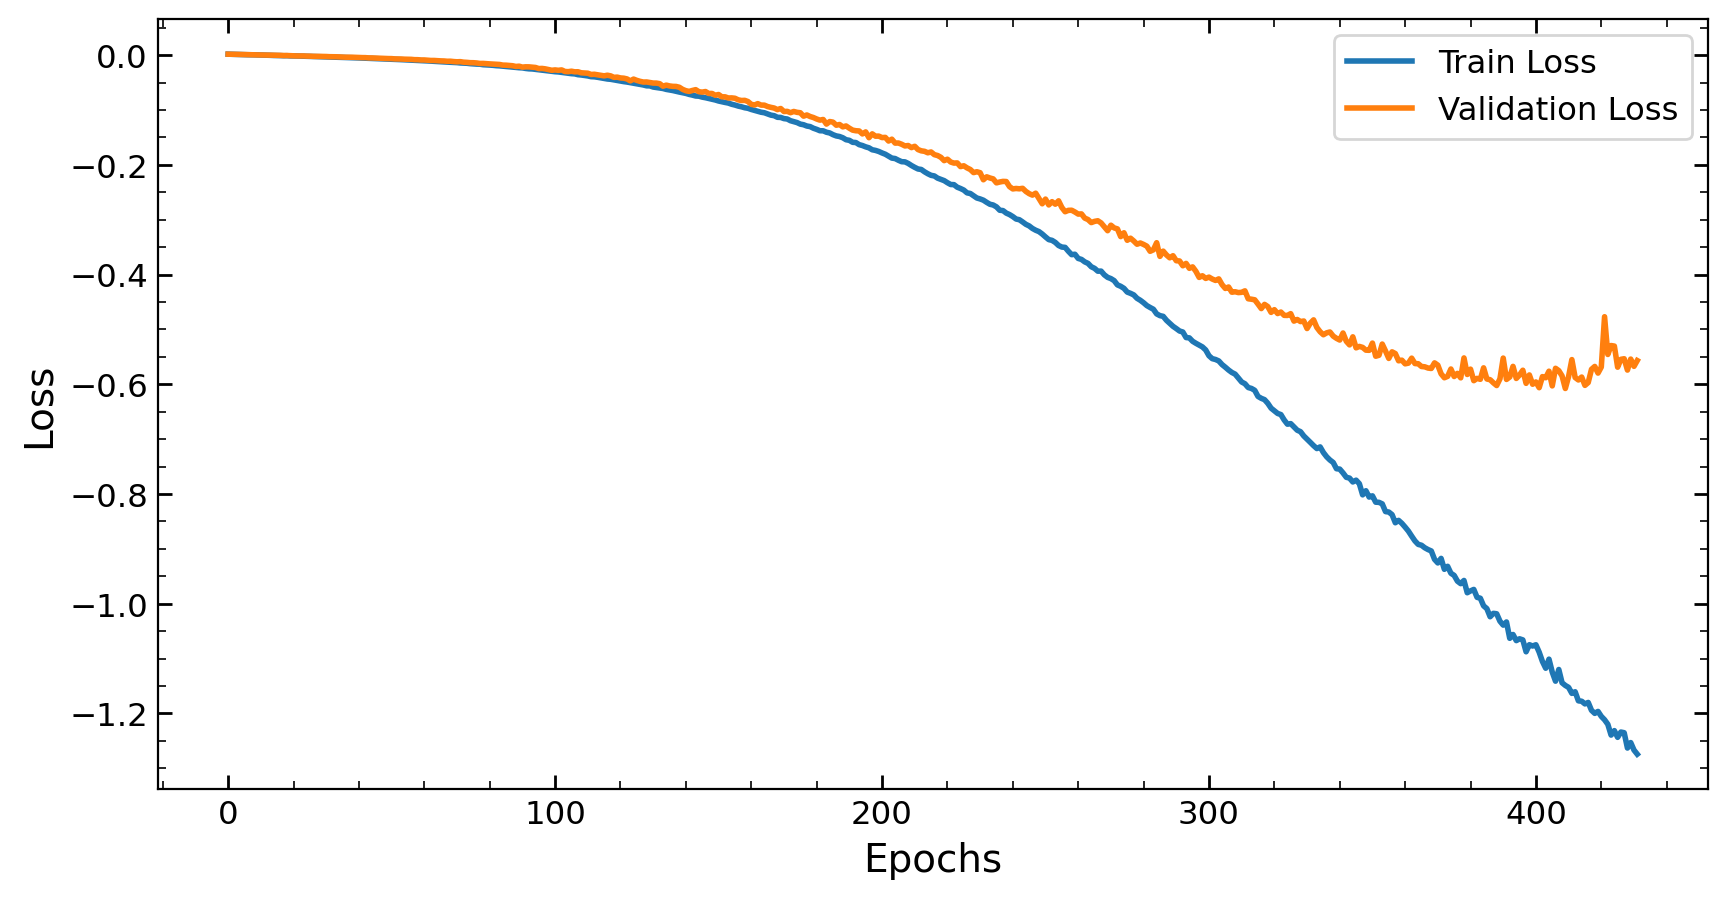

In [16]:
f, ax = plt.subplots(1, 1, figsize=(10, 5))
# ax.semilogy()
ax.plot(summary['training_loss'], label='Train Loss')
ax.plot(summary['validation_loss'], label='Validation Loss')
ax.legend()
ax.set(xlabel='Epochs', ylabel='Loss')

In [17]:
from sklearn.metrics import classification_report

yhat_test = runner.predict(X_test).detach().numpy()
yhat_label = yhat_test > 0

# Generate and print the classification report
report = classification_report(y_test, yhat_label, target_names=["Infinite Euclidean", "3-Torus"])
print(report)


                    precision    recall  f1-score   support

Infinite Euclidean       0.89      0.86      0.87       990
           3-Torus       0.86      0.90      0.88      1010

          accuracy                           0.88      2000
         macro avg       0.88      0.88      0.88      2000
      weighted avg       0.88      0.88      0.88      2000



Text(0, 0.5, 'Density')

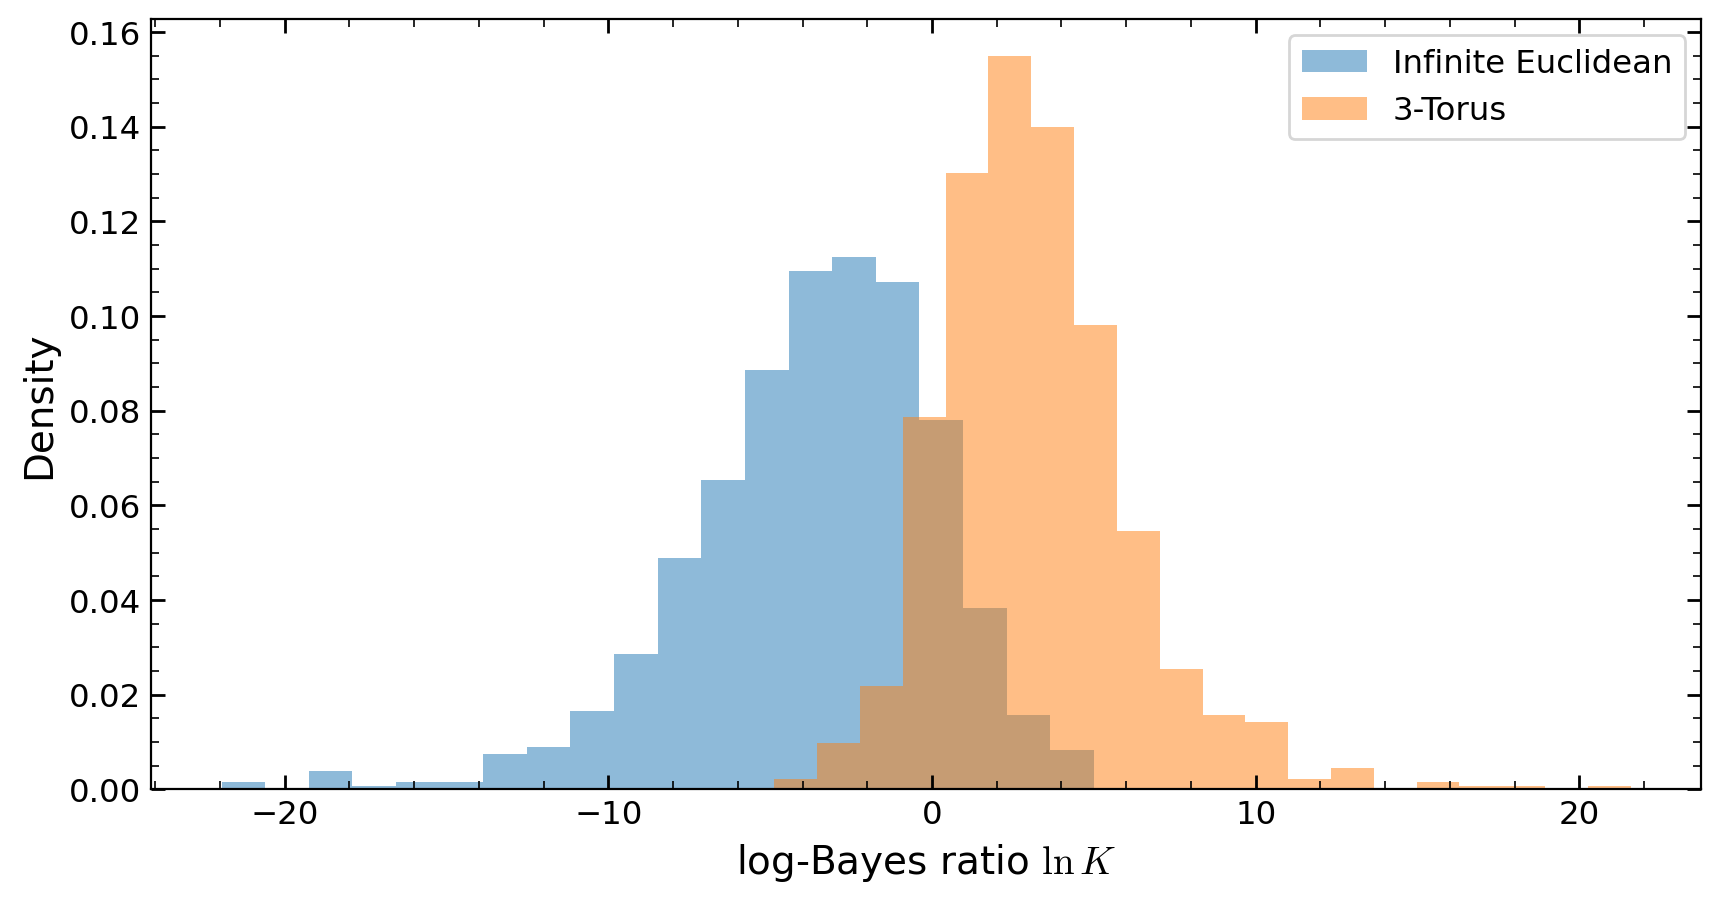

In [18]:
f, ax = plt.subplots(1, 1, figsize=(10, 5))
m = y_test==0

bins = 20 # np.linspace(-200,100, 50)
ax.hist(yhat_test[m], label='Infinite Euclidean', bins=bins, alpha=0.5, density=True)
ax.hist(yhat_test[~m], label='3-Torus', bins=bins, alpha=0.5, density=True)
ax.legend()
ax.set_xlabel(r'log-Bayes ratio $\ln K$')
ax.set_ylabel('Density')